In [1]:
import os
import sys
# Use local biomni
sys.path.insert(0, "/home/runai-home/Biomni/")

In [2]:
from biomni.cogzero.prompt.retriever import RETRIEVER_PROMPT
from biomni.cogzero.prompt.proposer import PROPOSER_PROMPT
from biomni.cogzero.prompt.solver import SOLVER_PROMPT

from biomni.cogzero.canonicalizer import compare_outputs
from biomni.cogzero.utils import clear_persistent_namespace, parse_solution_as_json, load_data, save_data, load_tasks_as_dict
from biomni.cogzero.nb_utils import *

In [3]:
import random
import re
import datasets
from pathlib import Path
from copy import deepcopy
from tqdm.auto import tqdm
from trl import apply_chat_template, is_conversational

In [4]:
ver = "v0"
model_id = "Qwen3-32B"
traj_dir = Path(f"/mlbio_scratch/kodryan/Biomni/data/generated/trajectories/{ver}/{model_id}")
all_traj_dict = load_data_dict(traj_dir)

In [5]:
dataset_dicts = load_data("/mlbio_scratch/kodryan/Biomni/data/all_sc_datasets.json")
extract_name = lambda d: '/'.join(d.rsplit('/', 3)[1:])
dataset_names = dict((d, extract_name(d)) for d in dataset_dicts)

In [6]:
for trial, trajs in all_traj_dict.items():
    for traj in trajs:
        traj["dataset_name"] = dataset_names[traj["dataset_path"]]

### Trajectories analysis

In [7]:
for trial, trajs in tqdm(all_traj_dict.items()):
    print(trial)
    print()
    for traj in trajs:
        messages = traj["memory_messages"]
        for m in messages:
            if m["type"] != "system":
                print(m["type"])
                print(m["content"])
                print(100 * '=')
        break

  0%|          | 0/16 [00:00<?, ?it/s]

trial_0

human
Using the provided single-nucleus RNA‑seq dataset (dataset1.h5ad), compute the mean Euclidean distance between pre‑treatment cells (where the 'Response' column is missing/NaN) and post‑treatment cells (where 'Response' is not NaN) for each unique value in the 'malignancy' column, based on the first 30 principal components stored in adata.obsm['X_pca']. Report the malignancy label that has the largest mean pre‑post distance. Answer format: a single token exactly matching one entry of the 'malignancy' column (shape: label).

INPUT DATA:
Path: /mlbio_scratch/videnovi/papers_BIBA/paper2/data/dataset1.h5ad
Description: snRNA-seq of all cells in high-risk Neuroblastoma before and after chemotherapy
ai
<think>
Okay, let's see. The user wants me to compute the mean Euclidean distance between pre-treatment and post-treatment cells for each malignancy type based on the first 30 principal components. Then, I need to find which malignancy label has the largest mean distance. 

First

In [8]:
for trial, trajs in all_traj_dict.items():
    print(f"{trial}")
    task_ids = [t["task_id"] for t in trajs]
    assert len(set(task_ids)) == len(task_ids)
    print(f"{len(task_ids) = }")
    print(f"{(task_ids == sorted(task_ids)) = }")
    print()

trial_0
len(task_ids) = 283
(task_ids == sorted(task_ids)) = True

trial_1
len(task_ids) = 283
(task_ids == sorted(task_ids)) = True

trial_2
len(task_ids) = 283
(task_ids == sorted(task_ids)) = True

trial_3
len(task_ids) = 283
(task_ids == sorted(task_ids)) = True

trial_4
len(task_ids) = 283
(task_ids == sorted(task_ids)) = False

trial_5
len(task_ids) = 283
(task_ids == sorted(task_ids)) = True

trial_6
len(task_ids) = 283
(task_ids == sorted(task_ids)) = True

trial_7
len(task_ids) = 283
(task_ids == sorted(task_ids)) = True

trial_8
len(task_ids) = 283
(task_ids == sorted(task_ids)) = True

trial_9
len(task_ids) = 283
(task_ids == sorted(task_ids)) = True

trial_10
len(task_ids) = 283
(task_ids == sorted(task_ids)) = False

trial_11
len(task_ids) = 283
(task_ids == sorted(task_ids)) = True

trial_12
len(task_ids) = 283
(task_ids == sorted(task_ids)) = True

trial_13
len(task_ids) = 283
(task_ids == sorted(task_ids)) = True

trial_14
len(task_ids) = 283
(task_ids == sorted(task_id

In [9]:
print_by_trials(all_traj_dict)

trial_0 	149.0 of 283 (52.65%)
trial_1 	163.0 of 283 (57.60%)
trial_2 	153.0 of 283 (54.06%)
trial_3 	146.0 of 283 (51.59%)
trial_4 	146.0 of 283 (51.59%)
trial_5 	162.0 of 283 (57.24%)
trial_6 	157.0 of 283 (55.48%)
trial_7 	161.0 of 283 (56.89%)
trial_8 	147.0 of 283 (51.94%)
trial_9 	153.0 of 283 (54.06%)
trial_10	161.0 of 283 (56.89%)
trial_11	154.0 of 283 (54.42%)
trial_12	161.0 of 283 (56.89%)
trial_13	153.0 of 283 (54.06%)
trial_14	149.0 of 283 (52.65%)
trial_15	161.0 of 283 (56.89%)
----------------------------------------
Total   	2476.0 of 4528 (54.68%)


In [10]:
traj_by_datasets = get_traj_by_datasets(all_traj_dict)
ds_stats = get_stats(traj_by_datasets)
datasets_list = list(ds_stats["rewards"].keys())
datasets_sorted = sorted(datasets_list, key=lambda t: ds_stats['rewards'][t])

In [11]:
print_by_datasets(ds_stats)

paper2/data/dataset1.h5ad                       	142.0 of 240.0 (59.17%)
paper2/data/dataset2.h5ad                       	123.0 of 256.0 (48.05%)
paper2/data/dataset3.h5ad                       	108.0 of 224.0 (48.21%)
paper4/data/dataset1.h5ad                       	120.0 of 208.0 (57.69%)
paper4/data/lymph_dataset.h5ad                  	95.0 of 240.0 (39.58%)
paper4/data/my_dataset.h5ad                     	58.0 of 176.0 (32.95%)
paper5/data/dataset2.h5ad                       	111.0 of 192.0 (57.81%)
paper5/data/VA_adipocytes.h5ad                  	140.0 of 256.0 (54.69%)
paper6/data/dataset1.h5ad                       	149.0 of 256.0 (58.20%)
paper7/data/dataset2.h5ad                       	118.0 of 240.0 (49.17%)
nature/paper1/cxg_data.h5ad                     	77.0 of 208.0 (37.02%)
nature/paper2/processed_MuSC_data.h5ad          	125.0 of 224.0 (55.80%)
nature/paper2/processed_human_muscle_data.h5ad  	161.0 of 256.0 (62.89%)
nature/paper2/processed_myonuclei_data.h5ad     	163.0

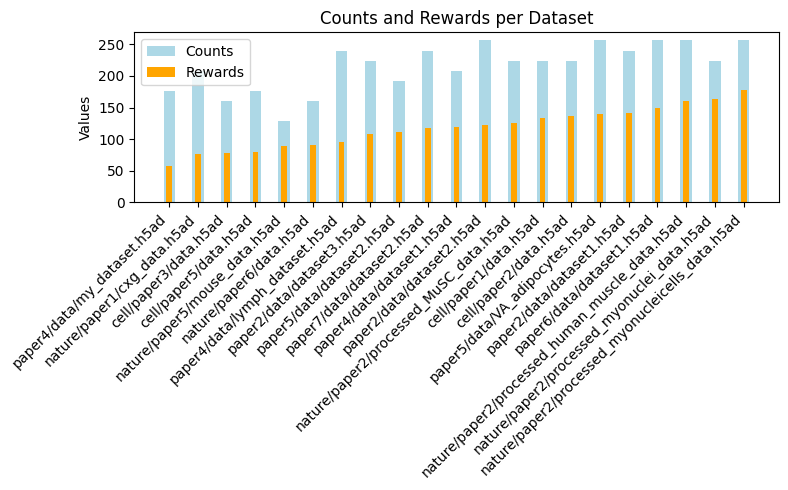

In [12]:
plot_ds_cr(ds_stats, datasets_sorted)

### Dataset preparation

In [13]:
# Manually copied from biomni.utils

def clean_message_content(content: str) -> str:
    """Clean message content by removing ANSI escape codes.

    This function removes ANSI escape sequences (like color codes) from text content
    that might be present in terminal output or console messages. This ensures clean
    text for markdown generation and PDF conversion.

    Args:
        content: The raw message content that may contain ANSI escape codes

    Returns:
        Cleaned content with ANSI escape codes removed

    Example:
        >>> clean_message_content("Hello \x1b[31mworld\x1b[0m!")
        "Hello world!"
    """
    import re

    return re.sub(r"\x1b\[[0-9;]*m", "", content)


def should_skip_message(clean_output: str) -> bool:
    """Check if message should be skipped during markdown generation.

    This function determines whether a message should be excluded from the final
    markdown output. It skips empty or meaningless messages but preserves important
    error messages that should be displayed to users.

    Args:
        clean_output: The cleaned message content to evaluate

    Returns:
        True if the message should be skipped, False otherwise

    Note:
        Parsing error messages are intentionally not skipped as they provide
        important feedback to users about conversation flow issues.
    """
    return (
        clean_output.strip() in ["", "None", "null", "undefined"]
        # Don't skip parsing error messages - they should be displayed and increment step counter
        # or "There are no tags" in clean_output
        # or "Execution terminated due to repeated parsing errors" in clean_output
    )

In [14]:
observation_pattern = r"<observation>(.*?)</observation>"
is_observation = lambda content: content.startswith("<observation>") and content.endswith("</observation>")

for trial, trajs in tqdm(all_traj_dict.items()):
    for traj in trajs:
        messages = traj["memory_messages"]
        observation_mask = [is_observation(message["content"]) for message in messages]
        # print(observation_mask[3:][::2])
        for i, message in enumerate(messages):
            assert message["type"] in ["system", "human", "ai"]
            if message["type"] == "ai":
                content = message["content"]
                clean_content = clean_message_content(content)
                
                if content != clean_content:
                    print(trial, "Content changed after cleaning")

                if should_skip_message(clean_content):
                    print(trial, "Bad message:", content)
                
                observation_matches = re.findall(observation_pattern, content, re.DOTALL | re.IGNORECASE)
                if observation_matches:
                    if not is_observation(content):
                        print(trial, "Observation in agent's message")

  0%|          | 0/16 [00:00<?, ?it/s]

trial_5 Observation in agent's message
trial_12 Observation in agent's message


In [15]:
def _role_from_type(t: str) -> str:
    if t == "system": return "system"
    if t == "human":  return "user"
    if t == "ai":     return "assistant"
    raise ValueError(f"Unknown type: {t}")

def convert_messages_to_rows(
    messages: list[dict[str, str]],
    skip_if_no_user_first: bool = False,
) -> list[dict[str, list[dict[str, str]]]]:
    """
    Convert a single agent trajectory (list of {'type','content'}) into TRL
    conversational prompt-completion rows, one per assistant turn, while:
      - Keeping <observation> messages as assistant *in the prompt only*.
      - Training on all other assistant messages (think/execute/solution allowed).
    """
    # Normalize to HF-style messages with roles
    msgs = [{"role": _role_from_type(m["type"]), "content": str(m["content"])}
            for m in messages]

    # (optional) require user-first after any system
    if skip_if_no_user_first:
        first_non_system = next((m for m in msgs if m["role"] != "system"), None)
        if not first_non_system or first_non_system["role"] != "user":
            return []

    rows = []
    for i, m in enumerate(msgs):
        if m["role"] != "assistant":
            continue
        content = m["content"]

        # Never train on observations — keep them purely as context
        if is_observation(content):
            continue

        prompt = msgs[:i]  # full context up to this assistant turn
        completion = [{"role": "assistant", "content": content}]
        rows.append({"prompt": prompt, "completion": completion})
    return rows

In [16]:
for trial, trajectories in tqdm(all_traj_dict.items(), total=len(all_traj_dict)):
    for traj in trajectories:
        messages = traj["memory_messages"]
        traj["pc_rows"] = convert_messages_to_rows(messages)

  0%|          | 0/16 [00:00<?, ?it/s]

In [17]:
def create_dataset(train_traj_list, test_traj_list=None, save_name=None):
    dataset_dict = {
        "train": datasets.Dataset.from_list(train_traj_list)
    }

    if test_traj_list is not None:
        dataset_dict.update(
            {
                "test": datasets.Dataset.from_list(test_traj_list)
            }
        )

    dataset = datasets.DatasetDict(dataset_dict)

    if save_name is not None:
        dataset.save_to_disk(os.path.join(dataset_dir, save_name))

    return dataset

In [18]:
tasks_dir = Path(f"/mlbio_scratch/kodryan/Biomni/data/generated/tasks/{ver}")
clean_tasks_path = tasks_dir / "clean.json"
clean_tasks = load_tasks_as_dict(clean_tasks_path)
task_ids = list(clean_tasks.keys())
print(f"All clean tasks: {len(task_ids)}")

All clean tasks: 283


In [19]:
traj_by_tasks = get_traj_by_tasks(all_traj_dict)
assert all(tid in task_ids for tid in traj_by_tasks), "Not all tasks present in trajectories!"
traj_list = sum([traj_by_tasks[task_id] for task_id in task_ids], [])

In [20]:
# We'll leave only successful trajectories to perform SFT on them

traj_list_filtered = [traj for traj in traj_list if traj['reward'] > 0]
pc_rows_filtered = sum((traj["pc_rows"] for traj in traj_list_filtered), [])
dataset = create_dataset(pc_rows_filtered)

In [21]:
dataset

DatasetDict({
    train: Dataset({
        features: ['prompt', 'completion'],
        num_rows: 9385
    })
})

In [22]:
n_data = 0
for trial, trajs in tqdm(all_traj_dict.items()):
    for traj in trajs:
        if not traj["reward"]:
            continue
        messages = traj["memory_messages"]
        response_mask = [(message["type"] == "ai" and not is_observation(message["content"])) for message in messages]
        n_data += sum(response_mask)
assert n_data == len(dataset["train"])

  0%|          | 0/16 [00:00<?, ?it/s]

#### Tokenization

In [23]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(f"Qwen/{model_id}")

Due to sequential `assistant` messages in a trajectory, tokenizer can act oddly (see example above).  
Therefore, we need to ensure that tokenization exactly follows the format used during inference.

* The **vLLM OpenAI server defaults** are:

  * `add_generation_prompt = true` (start a **new assistant** turn). ([VLLM Docs][1])
  * `continue_final_message = false` (do **not** continue the last assistant message). ([VLLM Docs][2])
  * `chat_template_kwargs` not provided → template-specific defaults. For **Qwen3**, **reasoning/thinking is enabled by default**. ([VLLM Docs][3])
  * The server uses the model’s **HF chat template**; by default it **does not trust a client-provided template**. ([Red Hat Docs][4])
  * If `add_generation_prompt=true` is used, the default **response role** is `"assistant"`. ([VLLM Docs][5])

So, tokenization on vLLM is: **apply the Qwen3 chat template to the whole `messages` list with `add_generation_prompt=true`, `continue_final_message=false`, `enable_thinking=true`**, then tokenize. That means if the prompt ends with an assistant `<observation>…</observation>`, vLLM will **start a fresh assistant turn**, not continue the observation. ([VLLM Docs][1])

In our case:

1. vLLM gets `prompt` and applies `processing_class.apply_chat_template(prompt, tokenize=True, add_generation_prompt=True)`.
2. The model generates completion, which after decoding becomes `completion`.
3. The correct way to mimic the inference pipeline is thus to append `completion` to the processed `prompt`.

[1]: https://docs.vllm.ai/en/v0.9.2/api/vllm/entrypoints/openai/protocol.html?utm_source=chatgpt.com "vllm.entrypoints.openai.protocol"
[2]: https://docs.vllm.ai/en/latest/api/vllm/entrypoints/llm.html?utm_source=chatgpt.com "vllm.entrypoints.llm"
[3]: https://docs.vllm.ai/en/latest/features/reasoning_outputs/?utm_source=chatgpt.com "Reasoning Outputs - vLLM"
[4]: https://docs.redhat.com/en/documentation/red_hat_ai_inference_server/3.1/html/vllm_server_arguments/vllm-server-usage_server-arguments?utm_source=chatgpt.com "Chapter 2. vLLM server usage"
[5]: https://docs.vllm.ai/en/v0.7.1/serving/openai_compatible_server.html?utm_source=chatgpt.com "OpenAI-Compatible Server - vLLM"
[6]: https://reference.langchain.com/python/integrations/langchain_openai/ChatOpenAI/?utm_source=chatgpt.com "ChatOpenAI | LangChain Reference"
[7]: https://huggingface.co/docs/transformers/main/chat_templating?utm_source=chatgpt.com "Chat templates"


In [24]:
def tokenize_fn(example, processing_class=tokenizer):
    "Manual tokenization to mimic the inference format."
    assert is_conversational(example), "A conversational format is expected"
    
    prompt = example["prompt"]
    completion = example["completion"]
    
    prompt_processed = processing_class.apply_chat_template(
        prompt,
        tokenize=False,
        add_generation_prompt=True,
        tools=example.get("tools"),
        **example.get("chat_template_kwargs", {}),
    )
    completion_processed = completion[0]["content"]
    # if completion_processed.endswith("</think>"):
    #     completion_processed += "\n\n"
    completion_processed += "<|im_end|>"
    
    output = {
        "prompt": prompt_processed,
        "completion": completion_processed,
    }

    return output

In [25]:
flattened = dataset.map(tokenize_fn)

Map:   0%|          | 0/9385 [00:00<?, ? examples/s]

In [26]:
flattened_ds_path = f"/mlbio_scratch/kodryan/Biomni/datasets/flattened_successful_trajectories/{ver}"
flattened.save_to_disk(flattened_ds_path)

Saving the dataset (0/1 shards):   0%|          | 0/9385 [00:00<?, ? examples/s]

### Train the model

In [55]:
from peft import LoraConfig
from trl import SFTTrainer, SFTConfig

In [56]:
peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules="all-linear",
    # modules_to_save=["lm_head", "embed_token"],
    task_type="CAUSAL_LM",
)

In [29]:
trainer = SFTTrainer(
    model="Qwen/Qwen3-4B",
    train_dataset=flattened["train"],
    args=SFTConfig(
        bf16=True,
        per_device_train_batch_size=2,
        max_length=40960,
        # Prompt-completion: loss on completion by default per docs
        # (set completion_only_loss=False if you want full-sequence loss)
        # Optional: packing=True once you're confident about token lengths
    ),
    peft_config=peft_config,
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Adding EOS to train dataset:   0%|          | 0/9385 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/9385 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/9385 [00:00<?, ? examples/s]

In [ ]:
trainer.train()

In [52]:
from dataclasses import dataclass, field
from typing import Any, Literal, Optional

import trl


@dataclass
class ScriptArguments(trl.ScriptArguments):
    """
    Extended version of ScriptArguments with support for dataset mixtures.

    Args:
        dataset_mixture (`dict[str, Any]` or `None`, *optional*, defaults to `None`):
            Configuration for creating dataset mixtures with advanced options.
            Format:
              dataset_mixture:
                datasets:
                  - id: dataset_id1
                    config: config_name
                    columns:
                      - col1
                      - col2
                    weight: 0.5
                  - id: dataset_id2
                    config: config_name
                    columns:
                      - col1
                      - col2
                    weight: 0.5
                seed: 42
                test_split_size: 0.1
    """

    # Override the dataset_name to make it optional
    dataset_name: Optional[str] = field(
        default=None,
        metadata={"help": "Dataset name. Can be omitted if using dataset_mixture."},
    )
    # dataset_load_from_disk: bool = field(
    #     default=False, metadata={"help": "Whether to use datasets.load_from_disk to load the dataset."}
    # )
    dataset_dir: Optional[str] = field(
        default=None,
        metadata={"help": "Dataset directory. If provided, dataset is loaded via datasets.load_from_disk."},
    )
    dataset_mixture: Optional[dict[str, Any]] = field(
        default=None,
        metadata={"help": "Configuration for creating dataset mixtures with advanced options like shuffling."},
    )

    def __post_init__(self):
        if self.dataset_name is None and self.dataset_mixture is None:
            raise ValueError("Either `dataset_name` or `dataset_mixture` must be provided")

        if self.dataset_mixture is not None:
            if not isinstance(self.dataset_mixture, dict) or "datasets" not in self.dataset_mixture:
                raise ValueError(
                    "dataset_mixture must be a dictionary with a 'datasets' key. "
                    "Expected format: {'datasets': [...], 'seed': int}"
                )

            datasets_list = []
            datasets_data = self.dataset_mixture.get("datasets", [])

            if isinstance(datasets_data, list):
                for dataset_config in datasets_data:
                    datasets_list.append(
                        DatasetConfig(
                            id=dataset_config.get("id"),
                            config=dataset_config.get("config"),
                            split=dataset_config.get("split", "train"),
                            columns=dataset_config.get("columns"),
                            weight=dataset_config.get("weight", 1.0),
                        )
                    )
            else:
                raise ValueError("'datasets' must be a list of dataset configurations")

            self.dataset_mixture = DatasetMixtureConfig(
                datasets=datasets_list,
                seed=self.dataset_mixture.get("seed", 0),
                test_split_size=self.dataset_mixture.get("test_split_size", None),
            )

            # Check that column names are consistent across all dataset configs
            columns_sets = [set(dataset.columns) for dataset in datasets_list if dataset.columns is not None]
            if columns_sets:
                first_columns = columns_sets[0]
                if not all(columns == first_columns for columns in columns_sets):
                    raise ValueError(
                        "Column names must be consistent across all dataset configurations in a mixture. "
                        f"Found different column sets: {[list(cols) for cols in columns_sets]}"
                    )
                    

@dataclass
class SFTConfig(trl.SFTConfig):
    """
    args for callbacks, benchmarks etc
    """

    benchmarks: list[str] = field(
        default_factory=lambda: [],
        metadata={"help": "The benchmarks to run after training."},
    )
    callbacks: list[str] = field(
        default_factory=lambda: [],
        metadata={"help": "The callbacks to run during training."},
    )
    chat_template: Optional[str] = field(default=None, metadata={"help": "The chat template to use."})
    system_prompt: Optional[str] = field(
        default=None,
        metadata={"help": "The optional system prompt to use for benchmarking."},
    )
    hub_model_revision: Optional[str] = field(
        default="main",
        metadata={"help": "The Hub model branch to push the model to."},
    )
    overwrite_hub_revision: bool = field(default=False, metadata={"help": "Whether to overwrite the Hub revision."})
    push_to_hub_revision: bool = field(default=False, metadata={"help": "Whether to push to a Hub revision/branch."})
    wandb_entity: Optional[str] = field(
        default=None,
        metadata={"help": ("The entity to store runs under.")},
    )
    wandb_project: Optional[str] = field(
        default=None,
        metadata={"help": ("The project to store runs under.")},
    )
    wandb_run_group: Optional[str] = field(
        default=None,
        metadata={"help": ("The group to store runs under.")},
    )

In [41]:
from trl import ModelConfig, SFTTrainer, TrlParser, get_peft_config, setup_chat_format

In [50]:
path_to_recipe = "/mlbio_scratch/kodryan/cognitia-zero/recipes/Qwen3-32B/sft/config_solver.yaml"
parser = TrlParser((ScriptArguments, SFTConfig, ModelConfig))
script_args, training_args, model_args = parser.parse_yaml_file(path_to_recipe)

/home/runai-home/my_env/lib/python3.12/site-packages/trl/trainer/model_config.py:193: FutureWarning: `torch_dtype` is deprecated and will be removed in version 0.27.0, please use `dtype` instead.
  warnings.warn(


In [58]:
model_args

ModelConfig(model_name_or_path='Qwen/Qwen3-32B', model_revision='main', dtype='bfloat16', trust_remote_code=False, attn_implementation='flash_attention_2', use_peft=True, lora_r=128, lora_alpha=32, lora_dropout=0.05, lora_target_modules='all-linear', lora_target_parameters=None, lora_modules_to_save=None, lora_task_type='CAUSAL_LM', use_rslora=False, use_dora=False, load_in_8bit=False, load_in_4bit=False, bnb_4bit_quant_type='nf4', use_bnb_nested_quant=False, torch_dtype='bfloat16')

In [57]:
peft_dict_1 = peft_config.to_dict()
peft_dict_2 = get_peft_config(model_args).to_dict()
for k in peft_dict_1:
    if peft_dict_1[k] != peft_dict_2[k]:
        print(k, peft_dict_1[k], peft_dict_2[k])

r 8 128
lora_dropout 0.0 0.05
